In [2]:
import pandas as pd
import os
import re
import numpy as np
import klib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D, Conv1D, MaxPooling1D

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


In [44]:
df = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False)

## Preprocessing

In [45]:
# Create 1 full Datetime column istead of two, Fix "?" characters, drop old date and time columns
df['Datetime'] = df['Date'] +" "+df['Time']
df = df.replace({"?":np.nan})
df['Datetime'] = pd.to_datetime(df.Datetime, format='%d/%m/%Y %H:%M:%S')
df.drop(["Date", "Time"], axis=1, inplace=True)

# Convert all columns from object to float for manipulation
lst = df.columns.to_list()
lst.remove("Datetime")
for col in lst:
    df[col] = df[col].astype(float)

# Set new datetime column as index and create a Time series
df = df.set_index("Datetime")

# Create three new dataframes with resampled values by hour, day and month
df_resample_hour = df.resample('h').mean()
df_resample_day = df.resample('D').mean()
df_resample_month = df.resample('M').mean()

# Fill the nan values for each one of the created resampled dataframes with the mean of the column
for temp_df in [df,df_resample_hour, df_resample_day,df_resample_month]:
    for col in list(temp_df.columns):
        temp_df[col] = temp_df[col].fillna(temp_df[col].mean())



## Exploratory Data Analysis

In [46]:
for temp_df in [df, df_resample_hour, df_resample_day,df_resample_month]:
    print("Shape of Dataframe: ", temp_df.shape)
    print("Dataframe missing values per column: ")
    for col in list(temp_df.columns):
        print("{}:                             {} nan values per column, {} percentage of all dataset.".format(
                                                col,
                                                str(temp_df[col].isna().sum()),
                                                 str(temp_df[col].isna().sum()/temp_df.shape[0]))
                                                 )
    print("----------------------------------------------------------------------------")

Shape of Dataframe:  (2075259, 7)
Dataframe missing values per column: 
Global_active_power:                             0 nan values per column, 0.0 percentage of all dataset.
Global_reactive_power:                             0 nan values per column, 0.0 percentage of all dataset.
Voltage:                             0 nan values per column, 0.0 percentage of all dataset.
Global_intensity:                             0 nan values per column, 0.0 percentage of all dataset.
Sub_metering_1:                             0 nan values per column, 0.0 percentage of all dataset.
Sub_metering_2:                             0 nan values per column, 0.0 percentage of all dataset.
Sub_metering_3:                             0 nan values per column, 0.0 percentage of all dataset.
----------------------------------------------------------------------------
Shape of Dataframe:  (34589, 7)
Dataframe missing values per column: 
Global_active_power:                             0 nan values per column, 

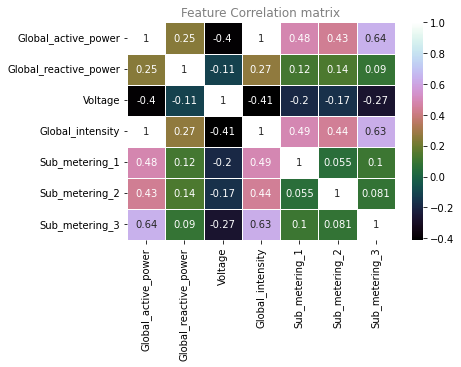

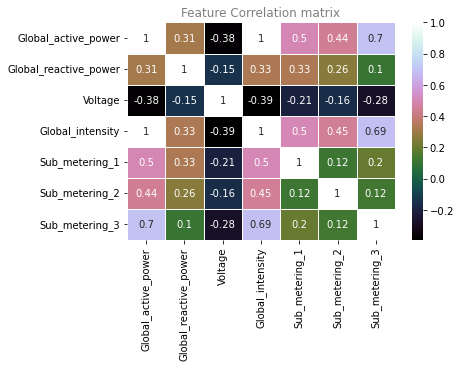

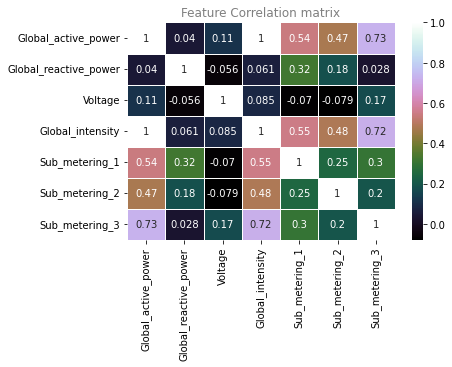

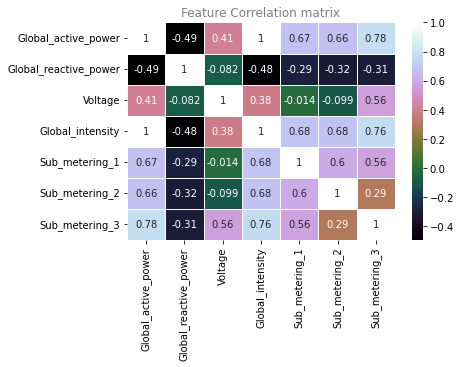

In [51]:
for i, temp_df in enumerate([df,df_resample_hour, df_resample_day,df_resample_month]):
    plt.figure(i)
    sns.heatmap(temp_df.corr(), annot = True, linewidths=.5, cmap="cubehelix")

    plt.title("Feature Correlation matrix", fontdict={"color":"grey"})
    plt.show()

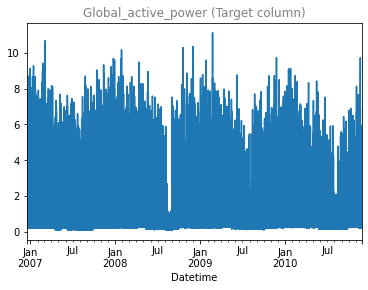

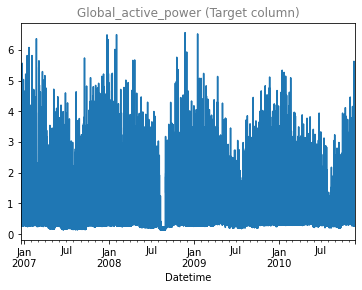

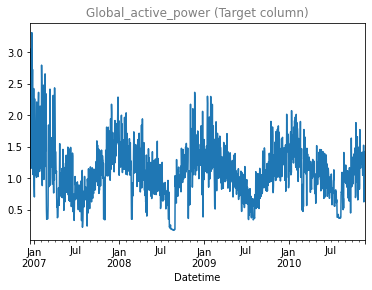

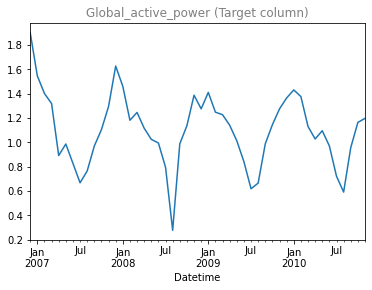

In [53]:
for i, temp_df in enumerate([df,df_resample_hour, df_resample_day,df_resample_month]):
    plt.figure(i)
    temp_df.Global_active_power.plot(title='Global_active_power resampled') 

    plt.title("Global_active_power (Target column)", fontdict={"color":"grey"})
    plt.show()

## Model Training

In [67]:
# Split the dataset into features and target
features = df_resample_hour.drop(["Global_active_power"], axis=1)
target = df_resample_hour["Global_active_power"]

# Split features and target to traning, validation and test set
train_X, test_X, train_y, test_y = train_test_split(features, target, test_size = 0.25, random_state = 42)
val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, test_size = 0.33, random_state = 42)

# Print the shapes
print(train_X.shape)
print(train_y.shape)
print(train_X.shape[0]/features.shape[0])

print(val_X.shape)
print(val_y.shape)
print(val_X.shape[0]/features.shape[0])

print(test_X.shape)
print(test_y.shape)
print(test_X.shape[0]/features.shape[0])

(25941, 6)
(25941,)
0.749978316805921
(5794, 6)
(5794,)
0.16750990199196275
(2854, 6)
(2854,)
0.08251178120211627


In [68]:
# Apply MinMaxscaler for the values
mm = MinMaxScaler(feature_range=(0, 1))
train_X = mm.fit_transform(train_X)
val_X = mm.transform(val_X)
test_X = mm.transform(test_X)

# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape) 

(25941, 1, 6) (25941,) (5794, 1, 6) (5794,) (2854, 1, 6) (2854,)


Epoch 1/20
371/371 - 12s - loss: 0.3220 - val_loss: 0.0324 - 12s/epoch - 32ms/step
Epoch 2/20
371/371 - 2s - loss: 0.0284 - val_loss: 0.0018 - 2s/epoch - 6ms/step
Epoch 3/20
371/371 - 2s - loss: 0.0189 - val_loss: 0.0031 - 2s/epoch - 6ms/step
Epoch 4/20
371/371 - 2s - loss: 0.0170 - val_loss: 0.0015 - 2s/epoch - 6ms/step
Epoch 5/20
371/371 - 2s - loss: 0.0158 - val_loss: 5.8686e-04 - 2s/epoch - 6ms/step
Epoch 6/20
371/371 - 2s - loss: 0.0153 - val_loss: 5.4961e-04 - 2s/epoch - 6ms/step
Epoch 7/20
371/371 - 2s - loss: 0.0146 - val_loss: 6.9613e-04 - 2s/epoch - 6ms/step
Epoch 8/20
371/371 - 2s - loss: 0.0138 - val_loss: 6.4413e-04 - 2s/epoch - 6ms/step
Epoch 9/20
371/371 - 2s - loss: 0.0132 - val_loss: 7.0551e-04 - 2s/epoch - 6ms/step
Epoch 10/20
371/371 - 2s - loss: 0.0122 - val_loss: 9.1600e-04 - 2s/epoch - 6ms/step
Epoch 11/20
371/371 - 2s - loss: 0.0114 - val_loss: 6.7088e-04 - 2s/epoch - 6ms/step
Epoch 12/20
371/371 - 2s - loss: 0.0111 - val_loss: 0.0010 - 2s/epoch - 6ms/step
Epoch 

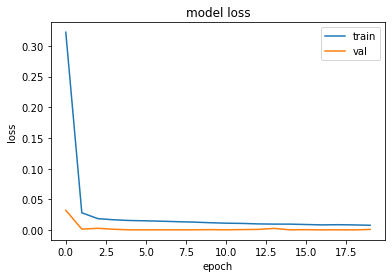

In [69]:
model = Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(val_X, val_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [70]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 6))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = mm.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.values.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = mm.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(r2_score(inv_y, inv_yhat))

90/90 [==============================] - 1s 3ms/step
Test RMSE: 0.029
0.9983711468910004


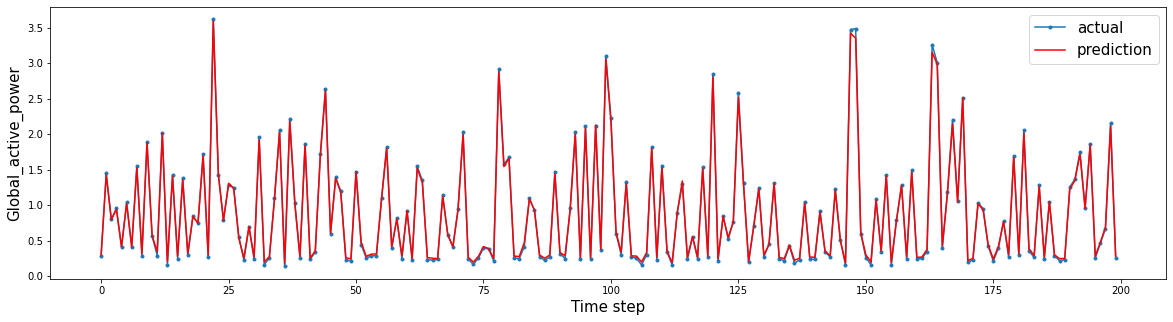

In [71]:
aa=[x for x in range(200)]
plt.figure(figsize=(20,5))
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()